In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory of current directory to the Python path
sys.path.insert(0, os.path.abspath('..'))

from src.utils.process_session import *
from src.utils.optostim import *

In [2]:
# metadata
Experiment = "test_data"
Animals = ["SP111", "SP112"]
Group = ["Control", "Control"]
Path_To_Raw_Data = "/home/sthitapati/Documents/sequence_data/bpod_raw_data"
Camera_Folder = "/home/sthitapati/Documents/sequence_data/SP_FlyCap"
Output_Folder = "/home/sthitapati/Documents/sequence_data/output"


In [3]:
current_animal = Animals[1]
# print(current_animal)

all_sessions_file_name = os.path.join(Output_Folder, current_animal, f'{current_animal}_transition_data_all_sessions.csv')
print(all_sessions_file_name)


/home/sthitapati/Documents/sequence_data/output/SP112/SP112_transition_data_all_sessions.csv


In [4]:
allsessions_DF = pd.read_csv(all_sessions_file_name)
allsessions_DF.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
0,0,1,22,2,2,122.5270,122.5454,123.8857,123.9791,1.3403,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
1,1,1,22,2,2,123.8857,123.9791,124.0053,124.0335,0.0262,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
2,2,1,22,2,2,124.0053,124.0335,124.0566,124.3226,0.0231,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
3,3,1,22,2,2,124.0566,124.3226,124.3291,124.3915,0.0065,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control
4,4,1,21,2,1,124.3291,124.3915,134.7244,134.7446,10.3329,...,NaN,1,"[90.0, 90.0, 90.0, 90.0]","[5.0, 5.0, 5.0, 5.0]",1,0,2023-04-21,Fri,SP112,Control


In [5]:
# get session settings

sessions_df = get_session_settings(Output_Folder, current_animal)
sessions_df.head()

,session_id,session,date,file_number,day,opto_session,experiment_type
0,0,00_20230421_115325_Fri,2023-04-21,115325,Fri,False,1_Training
1,1,01_20230422_151343_Sat,2023-04-22,151343,Sat,False,1_Training
2,2,02_20230423_184215_Sun,2023-04-23,184215,Sun,False,1_Training
3,3,03_20230424_135300_Mon,2023-04-24,135300,Mon,False,1_Training
4,4,04_20230425_134800_Tue,2023-04-25,134800,Tue,False,1_Training


In [6]:
# get list of all sessions with opto_stim

opto_session_ids = get_opto_sessions(sessions_df)
print(opto_session_ids)

[36, 37, 38, 39, 40, 41, 42, 43, 45]


In [7]:
# make a dataframe by filtering for opto sessions with allsessions_DF['session_id'] = opto_session_ids

opto_df = allsessions_DF[allsessions_DF['session_id'].isin(opto_session_ids)]
opto_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
118533,0,1,26,2,6,36.2121,36.6108,36.9676,36.9959,0.3568,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118534,1,1,66,6,6,36.9676,36.9959,37.0260,37.2329,0.0301,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118535,2,1,66,6,6,37.0260,37.2329,37.2395,37.2459,0.0066,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118536,3,1,63,6,3,37.2395,37.2459,37.6719,37.7833,0.4260,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control
118537,4,1,37,3,7,37.6719,37.7833,38.0772,38.3069,0.2939,...,2.0,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13421,36,2023-07-11,Tue,SP112,Control


In [8]:
# info

opto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32481 entries, 118533 to 154967
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     32481 non-null  int64  
 1   trial_id                       32481 non-null  int64  
 2   transition_type                32481 non-null  int64  
 3   start_poke_port                32481 non-null  int64  
 4   end_poke_port                  32481 non-null  int64  
 5   start_poke_in_timestamp        32481 non-null  float64
 6   start_poke_out_timestamp       32481 non-null  float64
 7   end_poke_in_timestamp          32481 non-null  float64
 8   end_poke_out_timestamp         32475 non-null  float64
 9   out_in_latency                 32481 non-null  float64
 10  in_in_latency                  32481 non-null  float64
 11  repeat_filter                  32481 non-null  int64  
 12  2s_time_filter_out_in          32481 non

In [9]:
# Count the occurrences of each unique value in 'opto_condition'
opto_condition_counts = opto_df['opto_condition'].value_counts()
print('summary of opto-transitions \n', opto_condition_counts)

# Count the occurrences of each unique value in 'opto_stimulated_port'
opto_stimulated_port_counts = opto_df['opto_stimulated_port'].value_counts()
print('specific ports \n', opto_stimulated_port_counts)

summary of opto-transitions 
 1.0    3960
Name: opto_condition, dtype: int64
specific ports 
 2.0    1050
1.0    1000
4.0     965
3.0     945
Name: opto_stimulated_port, dtype: int64


In [10]:
# count number of control trials
nan_counts_opto_condition = opto_df['opto_condition'].isna().sum()
print('opto_stim', nan_counts_opto_condition)

nan_counts_opto_stimulated_port = opto_df['opto_stimulated_port'].isna().sum()
print('all_ports', nan_counts_opto_stimulated_port)

opto_stim 28521
all_ports 28521


In [11]:
# now just look at control data and develop plotting functionality

control_df = opto_df[opto_df['opto_condition'].isna()]
control_df.head()

,Unnamed: 0,trial_id,transition_type,start_poke_port,end_poke_port,start_poke_in_timestamp,start_poke_out_timestamp,end_poke_in_timestamp,end_poke_out_timestamp,out_in_latency,...,opto_stimulated_port,training_level,led_intensities_ports_2_3_4_5,reward_amounts_ports_1_2_3_4,cumulative_trial_id,session_id,date,day,animal_id,group
118541,8,2,16,1,6,39.6320,39.6880,40.2369,40.3083,0.5489,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118542,9,2,63,6,3,40.2369,40.3083,40.6669,41.0318,0.3586,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118543,10,2,37,3,7,40.6669,41.0318,41.3113,41.4741,0.2795,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118544,11,2,72,7,2,41.3113,41.4741,42.2490,42.4246,0.7749,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control
118545,12,2,21,2,1,42.2490,42.4246,42.7294,42.7822,0.3048,...,NaN,50,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",13422,36,2023-07-11,Tue,SP112,Control


In [12]:
control_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28521 entries, 118541 to 154967
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28521 non-null  int64  
 1   trial_id                       28521 non-null  int64  
 2   transition_type                28521 non-null  int64  
 3   start_poke_port                28521 non-null  int64  
 4   end_poke_port                  28521 non-null  int64  
 5   start_poke_in_timestamp        28521 non-null  float64
 6   start_poke_out_timestamp       28521 non-null  float64
 7   end_poke_in_timestamp          28521 non-null  float64
 8   end_poke_out_timestamp         28515 non-null  float64
 9   out_in_latency                 28521 non-null  float64
 10  in_in_latency                  28521 non-null  float64
 11  repeat_filter                  28521 non-null  int64  
 12  2s_time_filter_out_in          28521 non

In [13]:
control_df.groupby(['end_poke_port', 'start_poke_port']).size().unstack()

start_poke_port,1,2,3,4,5,6,7,8
end_poke_port,,,,,,,,
1,1790.0,3495.0,75.0,6.0,3.0,283.0,287.0,NaN
2,436.0,803.0,216.0,3.0,10.0,443.0,3428.0,2.0
3,366.0,282.0,1043.0,14.0,5.0,3744.0,511.0,5.0
4,4.0,4.0,3.0,1.0,1.0,4.0,7.0,3.0
5,19.0,8.0,NaN,1.0,12.0,3.0,1.0,NaN
6,3332.0,554.0,585.0,NaN,12.0,1603.0,256.0,1.0
7,21.0,49.0,4100.0,NaN,NaN,312.0,349.0,4.0
8,NaN,NaN,1.0,3.0,NaN,2.0,9.0,7.0


In [14]:
# Create mapping from old port numbers to new names
port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5'}

# If there are other ports not included in the correct sequence, map them to X, Y, Z
# Note: replace 4, 5, 8 with actual port numbers if different
port_mapping.update({4: 'port X', 5: 'port Y', 8: 'port Z'})

In [151]:
def plot_transition_matrix(df, normalize=False, display_numbers=False, additional_title=None, ax=None):
    # Create a copy of df
    df_copy = df.copy()

    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by end and start port and count the number of each transition
    transition_counts = df_copy.groupby(['end_poke_port', 'start_poke_port']).size().unstack(fill_value=0)

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)

    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values)

    if normalize:
        # Normalize rows to get transition probabilities
        row_sums = transition_counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / row_sums
        colorbar_label = 'Transition Probabilities'
        title = 'State Transition Matrix'
    else:
        colorbar_label = 'Number of Transitions'
        title = 'Absolute Transition Matrix'

    # Add the additional title if specified by the user
    if additional_title:
        title = title + '\n' + additional_title

    # If no Axes object was provided, create a new one
    if ax is None:
        ax = plt.gca() # If no ax provided, use the current axes

    # Plotting transition matrix, only select first 4 columns (Start Ports 1 to 4)
    sns.heatmap(transition_counts[:, :4], annot=display_numbers, cmap='YlGnBu', 
                xticklabels=['port 1', 'port 2', 'port 3', 'port 4'], 
                yticklabels=['port Z', 'port Y', 'port X', 'port 5', 'port 4', 'port 3', 'port 2', 'port 1'],
                ax=ax)  # Use the 'ax' in your plotting command
    ax.set_title(title)
    ax.set_xlabel('Start Port')
    ax.set_ylabel('End Port')
    ax.set_aspect('equal')  # set aspect ratio

    # Add a colorbar with label
    cbar = ax.collections[0].colorbar
    cbar.set_label(colorbar_label)

    # set dpi to 300 to get a higher resolution
    save_path = os.path.join(Output_Folder, current_animal, 'plots', f'{additional_title}_heatmap.png')

    # Ensure the directory exists
    os.makedirs(os.path.join(Output_Folder, current_animal, 'plots'), exist_ok=True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)

    plt.show()


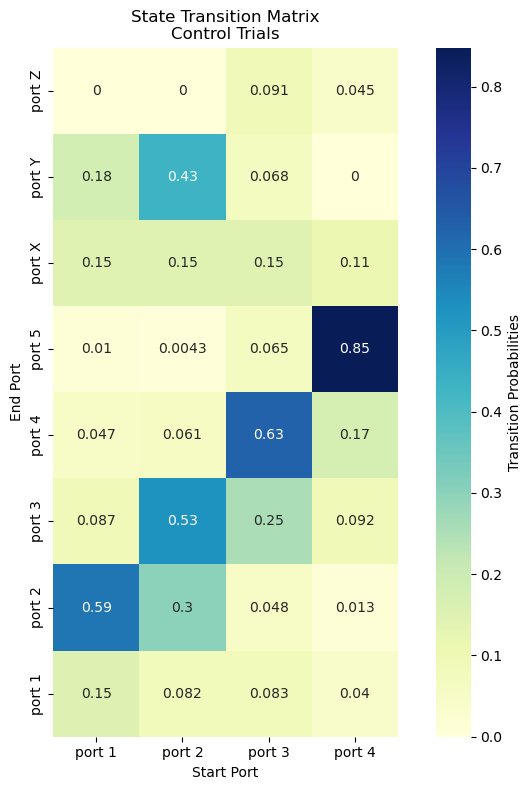

In [159]:

fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(control_df, normalize=True, display_numbers=True, additional_title= 'Control Trials')

In [153]:
# now make a dataframe with optostim in specific ports only

optostim_port_1 = opto_df[opto_df['opto_stimulated_port'] == 1]
optostim_port_2 = opto_df[opto_df['opto_stimulated_port'] == 2]
optostim_port_3 = opto_df[opto_df['opto_stimulated_port'] == 3]
optostim_port_4 = opto_df[opto_df['opto_stimulated_port'] == 4]


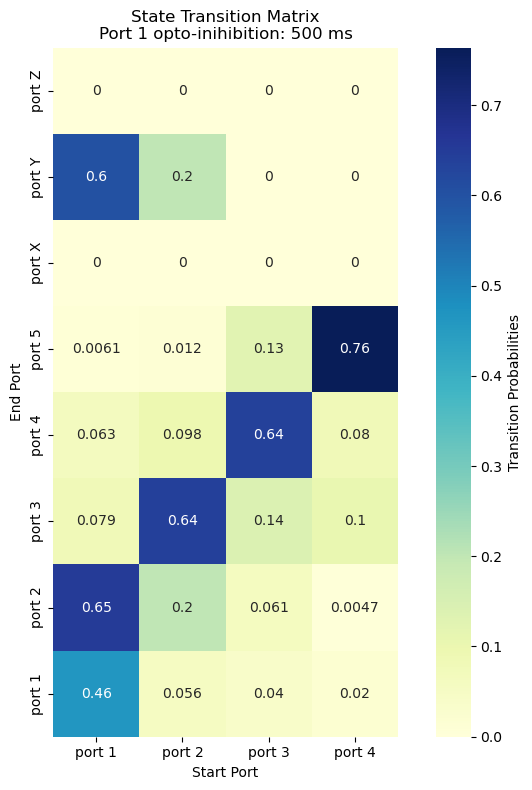

In [154]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_1, normalize=True, display_numbers=True, additional_title= 'Port 1 opto-inihibition: 500 ms')

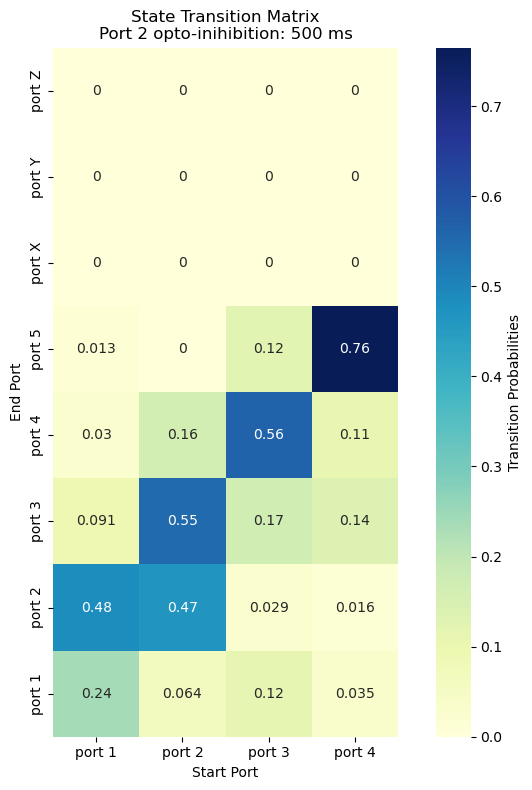

In [155]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_2, normalize=True, display_numbers=True, additional_title= 'Port 2 opto-inihibition: 500 ms')

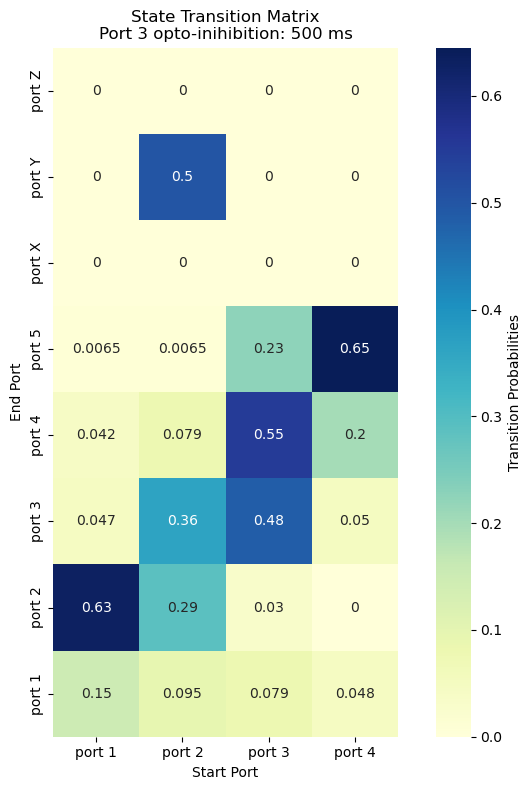

In [156]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_3, normalize=True, display_numbers=True, additional_title= 'Port 3 opto-inihibition: 500 ms')

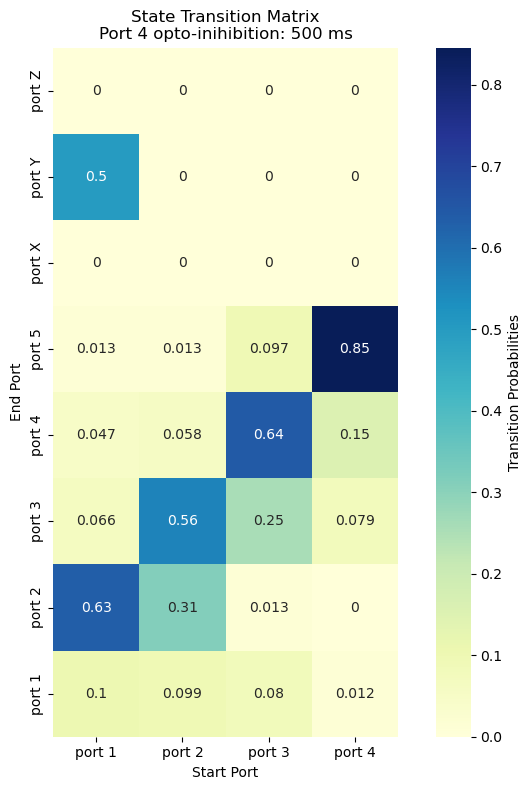

In [157]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_transition_matrix(optostim_port_4, normalize=True, display_numbers=True, additional_title= 'Port 4 opto-inihibition: 500 ms')

In [158]:
# extract trial_ids of rows with opto_condition == 1

# opto_df[opto_df['opto_condition'] == 1]['cumulative_trial_id'].unique()

# Set n and m values
n = 5  # forward steps
m = 3  # backward steps

# List of unique trial IDs where opto_condition is 1
trials_with_opto = opto_df[opto_df['opto_condition'] == 1]['cumulative_trial_id'].unique()

# Initialize empty list to hold selected trial IDs
selected_trial_ids = []

# Iterate over trial IDs
for trial_id in trials_with_opto:
    # Compute the range of trial IDs that are n steps forward and m steps back
    trial_range = list(range(trial_id - m, trial_id + n + 1))
    
    # Add the trial IDs in the range to the selected trial IDs list
    selected_trial_ids.extend(trial_range)

# Remove duplicate trial IDs
selected_trial_ids = list(set(selected_trial_ids))

# Print the selected trial IDs
print(selected_trial_ids)


[16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395, 16396, 16397, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16447, 16448, 16449, 16450, 16451, 16452, 16453, 16454, 16455, 16456, 16457, 16458, 16459, 16460, 16461, 16462, 16463, 16464, 16465, 16466, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478, 16479, 16487, 16488, 16489, 16490, 16491, 16492, 16493, 16494, 16495, 16496, 16497, 16498, 16499, 16500, 16501, 16502, 16503, 16504, 16515, 16516, 16517, 16518, 16519, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527, 16528, 16529, 16530, 16531, 16532, 16533, 16534, 16535, 16537, 16538, 16539, 16540, 16541, 16542, 16543, 16544, 16545, 16547, 16548, 16549, 16550, 16551, 16552, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568

In [120]:
opto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32481 entries, 118533 to 154967
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     32481 non-null  int64  
 1   trial_id                       32481 non-null  int64  
 2   transition_type                32481 non-null  int64  
 3   start_poke_port                32481 non-null  int64  
 4   end_poke_port                  32481 non-null  int64  
 5   start_poke_in_timestamp        32481 non-null  float64
 6   start_poke_out_timestamp       32481 non-null  float64
 7   end_poke_in_timestamp          32481 non-null  float64
 8   end_poke_out_timestamp         32475 non-null  float64
 9   out_in_latency                 32481 non-null  float64
 10  in_in_latency                  32481 non-null  float64
 11  repeat_filter                  32481 non-null  int64  
 12  2s_time_filter_out_in          32481 non

In [109]:
# Set n and m values
n = 1  # forward steps
m = 0  # backward steps

# List of unique trial IDs where opto_condition is 1
trials_with_opto = opto_df[opto_df['opto_condition'] == 1]['cumulative_trial_id'].unique()

# List of unique control trial IDs
control_trials = control_df['cumulative_trial_id'].unique()

# Initialize empty list to hold selected control trial IDs
selected_control_trial_ids = []

# Iterate over trial IDs
for trial_id in trials_with_opto:
    # Compute the range of trial IDs that are n steps forward and m steps back
    trial_range = list(range(trial_id - m, trial_id + n + 1))
    
    # Select the trial IDs in the range that are also in the control trials
    selected_trials = [trial for trial in trial_range if trial in control_trials]
    
    # Add the selected control trial IDs to the selected list
    selected_control_trial_ids.extend(selected_trials)

# Remove duplicate trial IDs
selected_control_trial_ids = list(set(selected_control_trial_ids))

# Print the selected control trial IDs
print(selected_control_trial_ids)
print(len(selected_control_trial_ids))



[14336, 16386, 16393, 14356, 14362, 16413, 14369, 16430, 16433, 14386, 16437, 14391, 14393, 16441, 16444, 14397, 16447, 16453, 16462, 16475, 14435, 14439, 14441, 16491, 16498, 14452, 16500, 14464, 16519, 14472, 16524, 14477, 14479, 16528, 16531, 14490, 14493, 16541, 14502, 16551, 14506, 16554, 16560, 14518, 16567, 14525, 14528, 16578, 16580, 16582, 16588, 14541, 16601, 14555, 14557, 14559, 16608, 14563, 14565, 16614, 14571, 14575, 16632, 14586, 14589, 16640, 16642, 16647, 14600, 14602, 14610, 14615, 16674, 14629, 14635, 16686, 14645, 14647, 16698, 14651, 16702, 14657, 16706, 14660, 16711, 14666, 16714, 14672, 14674, 16728, 14681, 16735, 16738, 14693, 14700, 14702, 16754, 16756, 14711, 16760, 16763, 16771, 14726, 14750, 14755, 16803, 16807, 16810, 16816, 14769, 16818, 16831, 14785, 16835, 14790, 14793, 16843, 14799, 16847, 14801, 14806, 16859, 14817, 14822, 14824, 16873, 16875, 14839, 16887, 14854, 16904, 14857, 14859, 16908, 14862, 14864, 16915, 14868, 16917, 16921, 14875, 16923, 16929

In [138]:
def compute_transition_matrix(df, normalize=False):
    # Create a copy of df
    df_copy = df.copy()
    # Mapping dictionary
    port_mapping = {2: 'port 1', 1: 'port 2', 6: 'port 3', 3: 'port 4', 7: 'port 5',
                    4: 'port X', 5: 'port Y', 8: 'port Z'}

    # Apply mapping to start_poke_port and end_poke_port
    df_copy['start_poke_port'] = df_copy['start_poke_port'].map(port_mapping)
    df_copy['end_poke_port'] = df_copy['end_poke_port'].map(port_mapping)

    # Group by end and start port and count the number of each transition
    transition_counts = df_copy.groupby(['end_poke_port', 'start_poke_port']).size().unstack(fill_value=0)

    # Reorder the columns and rows
    ordered_ports = ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port X', 'port Y', 'port Z']
    transition_counts = transition_counts.reindex(index=ordered_ports[::-1], columns=ordered_ports)

    # Convert to numpy array for easier manipulation and replace np.nan with 0
    transition_counts = np.nan_to_num(transition_counts.values)

    if normalize:
        # Normalize rows to get transition probabilities
        row_sums = transition_counts.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1e-10  # replace 0 sums with a small number to avoid division by zero
        transition_counts = transition_counts / row_sums

    # Convert back to DataFrame
    transition_counts = pd.DataFrame(transition_counts, index=ordered_ports[::-1], columns=ordered_ports)
    return transition_counts


In [148]:
# plot transition matrix

transition_matrix = compute_transition_matrix(control_df, normalize=True)
transition_matrix

,port 1,port 2,port 3,port 4,port 5,port X,port Y,port Z
port Z,0.000000,0.000000,0.090909,0.045455,0.409091,0.136364,0.000000,0.318182
port Y,0.181818,0.431818,0.068182,0.000000,0.022727,0.022727,0.272727,0.000000
port X,0.148148,0.148148,0.148148,0.111111,0.259259,0.037037,0.037037,0.111111
port 5,0.010134,0.004343,0.064529,0.847983,0.072182,0.000000,0.000000,0.000827
port 4,0.047236,0.061307,0.627136,0.174707,0.085595,0.002345,0.000838,0.000838
port 3,0.087340,0.525303,0.252720,0.092228,0.040359,0.000000,0.001892,0.000158
port 2,0.588483,0.301398,0.047651,0.012628,0.048325,0.001010,0.000505,0.000000
port 1,0.150346,0.081633,0.082943,0.040442,0.641827,0.000562,0.001872,0.000374
